<a href="https://colab.research.google.com/github/BRomans/IdMind/blob/main/eeg_biometrics_autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Load libraries & initialise environment

In [5]:
# import libraries
import os
import csv
import random
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)
%matplotlib inline

from google.colab import drive
from sklearn.preprocessing import MinMaxScaler, RobustScaler, QuantileTransformer
from copy import deepcopy
from sklearn.externals import joblib
from numpy.random import seed
from keras.layers import Input, Dropout, Dense, LSTM, TimeDistributed, Reshape, \
          RepeatVector, MaxPooling1D, Conv1D, Flatten, Conv1DTranspose, UpSampling1D, \
          AveragePooling1D
from keras.models import Model, Sequential
from keras.optimizers import Adam
from keras import regularizers
from keras import backend as K
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.utils import to_categorical

from tensorflow.python.client import device_lib
# print(device_lib.list_local_devices())

In [6]:
drive.mount("/content/drive")
dirpath = "/content/drive/MyDrive/ml2-eeg-biometrics/train-test-data/" 

Mounted at /content/drive


In [7]:
# Seed value
# Apparently you may use different seed values at each stage
seed_value = 10
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# 1. Set `PYTHONHASHSEED` environment variable at a fixed value
os.environ['PYTHONHASHSEED']=str(seed_value)

# 2. Set `python` built-in pseudo-random generator at a fixed value

random.seed(seed_value)

# 3. Set `numpy` pseudo-random generator at a fixed value
np.random.seed(seed_value)

# 4. Set the `tensorflow` pseudo-random generator at a fixed value
tf.compat.v1.set_random_seed(seed_value)

# 5. Configure a new global `tensorflow` session
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)

## Load & Process Data




##### Load data

To begin with, we load the 3 parts of the dataset, training, test and validation that we split in the pre-processing phase.

In [8]:
def load_datasets():
  x_train = np.asarray(np.load(dirpath + 'x_train.npy')).astype(np.float32)
  x_test = np.asarray(np.load(dirpath + 'x_test.npy', allow_pickle=True)).astype(np.float32)
  x_valid = np.asarray(np.load(dirpath + 'x_valid.npy', allow_pickle=True)).astype(np.float32)
  return x_train, x_test, x_valid

In [9]:
x_train_unscaled, x_test_unscaled, x_valid_unscaled  = load_datasets()
print("Data loaded. Shapes:")
print(x_train_unscaled.shape, x_test_unscaled.shape, x_valid_unscaled.shape)

Data loaded. Shapes:
(6665, 2500, 9) (419, 2500, 9) (1300, 2500, 9)


##### Plot distributions of unscaled data

In [10]:
cols = ['Statistic','F3', 'F4', 'FC3', 'FC4', 'C3', 'Cz', 'C4', 'CP3', 'CP4']
def data_summary(dataset, label):
  """ 
  input:
    dataset     the three dimensional input (n_samples, n_timepoints, n_features) 

    Prints histograms for the 9 features individually
  returns: 
    summ_df     pd.DataFrame containing summary statistics for the 9 features.
  """
  data = dataset.reshape((dataset.shape[0] * dataset.shape[1], dataset.shape[2])) # Reshape to 2D (n_samples*n_timepoints, n_features)
  
  # Calculate the summary statistics.
  min   = data.min(axis=0).reshape(1, data.shape[1])                  # Calculate the minimum over the rows for each column.
  max   = data.max(axis=0).reshape(1, data.shape[1])                  # Then reshape the result to one row and n_cols=n_features, to make it easier to combine later.
  mean  = data.mean(axis=0).reshape(1, data.shape[1])
  var   = data.var(axis=0).reshape(1, data.shape[1])
  q01   = np.quantile(data, 0.01, axis=0).reshape(1, data.shape[1])
  q99   = np.quantile(data, 0.99, axis=0).reshape(1, data.shape[1])

  names=np.array([['min','max','mean','var','1st percentile', '99th percentile']]).reshape(6,1) # Create a column of names for the summary stats.
  stats = np.concatenate((min,max,mean,var,q01,q99), axis=0)          # Combine the summary stats in one array

  summ = np.concatenate((names, np.round(stats, 4)), axis=1)          # Combine the summary stats with their names.
  summ_df = pd.DataFrame(summ, columns=cols)                          # Create a dataframe and supply the channel names as columns.

  # Plot histograms per channel.
  fig, axes = plt.subplots(3,3, figsize = (9,9))
  axes=axes.ravel()
  for i in range(9): # Loop through the channels.
    axes[i].hist(data[:,i], range= (q01[0,i], q99[0,i]),   density=True)    # Add histogram subplot for the values of that channel.
    axes[i].title.set_text(cols[i+1])                                       # Add a title with the channel name.
  fig.suptitle("Distribution for each channel (between 1st & 99th percentile) of " + label + " dataset" , size=16)
  fig.tight_layout(rect=[0, 0.03, 1, 0.95])                                 # Cut the plot space to make space for the global title.

  return summ_df

In [ ]:
# Plot distributions of each channel.
unscaled_training_summary = data_summary(x_train_unscaled, "Training")
unscaled_test_summary = data_summary(x_test_unscaled, "Test")
unscaled_valid_summary = data_summary(x_valid_unscaled, "Validation")

### Band-pass filter

##### Create the filters and apply across the whole data

In [11]:
from scipy import signal
from copy import deepcopy

low_cut = 0.1
high_cut = 50.0

bp = signal.butter(10, (low_cut,high_cut), 'bp', fs=500, output='sos') # Create the filter. fs is the sampling rate.

# Create copies of the data
x_train_filtered = deepcopy(x_train_unscaled)         # After running once in the session, I comment these out because otherwise if you re-run the cell it eats RAM.
x_test_filtered = deepcopy(x_test_unscaled)
x_valid_filtered = deepcopy(x_valid_unscaled)

print(x_train_filtered.shape)

x_train_filtered = signal.sosfilt(bp, x_train_filtered, axis=1)
x_valid_filtered = signal.sosfilt(bp, x_valid_filtered, axis=1)

(6665, 2500, 9)


In [12]:
# How many values lay beyond a threshold?
threshold = 85

outliers_pre_BP = abs(x_train_unscaled) > threshold
outliers_post_BP = abs(x_train_filtered) > threshold
                                
print("Before BP filtering, {0:.2f}% of all values lay outside ±{1}".format((100*np.sum(outliers_pre_BP))/(6665*2500*9), threshold))
print("After BP filtering, {0:.2f}% of all values lay outside ±{1}".format((100*np.sum(outliers_post_BP))/(6665*2500*9), threshold))

 # Number of samples with at least value outside threshold.
print("After BP filtering, there are {0} samples with at least one value outside ±{1}".format(np.sum(np.max(outliers_post_BP, axis=(1,2))), threshold))

Before BP filtering, 1.56% of all values lay outside ±85
After BP filtering, 0.60% of all values lay outside ±85
After BP filtering, there are 1347 samples with at least one value outside ±85


#### Apply scaling with quantile transformer

In [13]:
transformer = QuantileTransformer(output_distribution='normal')

# Create copies so the original data remains unaltered.
x_train = deepcopy(x_train_filtered)
x_valid = deepcopy(x_valid_filtered)
x_test = deepcopy(x_test_filtered)

# Get the dimensionality for re-shaping.
n_samples, n_timepoints, n_features = x_train.shape
n_samples_valid = x_valid.shape[0]
n_samples_test = x_test.shape[0]

# Re-shape to 2D for the scaler.
x_train = x_train.reshape((n_samples*n_timepoints, n_features))        
x_valid = x_valid.reshape((n_samples_valid*n_timepoints, n_features))
x_test = x_test.reshape((n_samples_test*n_timepoints, n_features))

# Fit and apply the scaler/transformer to the datasets.
x_train = transformer.fit_transform(x_train)         
x_valid = transformer.transform(x_valid)            
x_test = transformer.transform(x_test)    

# Re-shape to 3D for input to the convolutional autoencoder.
x_train = x_train.reshape((n_samples, n_timepoints, n_features)) 
x_valid = x_valid.reshape((n_samples_valid, n_timepoints, n_features)) 
x_test = x_test.reshape((n_samples_test, n_timepoints, n_features))

,Statistic,F3,F4,FC3,FC4,C3,Cz,C4,CP3,CP4
0,min,-5.1993,-5.1993,-5.1993,-5.1993,-5.1993,-5.1993,-5.1993,-5.1993,-5.1993
1,max,5.1993,5.1993,5.1993,5.1993,5.1993,5.1993,5.1993,5.1993,5.1993
2,mean,0.0002,-0.0023,0.0055,0.0017,-0.0008,-0.0027,-0.0071,-0.0035,-0.0023
3,var,0.9999,0.9961,0.9921,1.0008,0.9965,0.9927,1.0033,1.0015,0.9913
4,1st percentile,-2.3193,-2.332,-2.3235,-2.3425,-2.3276,-2.3356,-2.3472,-2.314,-2.3432
5,99th percentile,2.3211,2.3242,2.3139,2.3255,2.3328,2.3101,2.3472,2.3283,2.3218


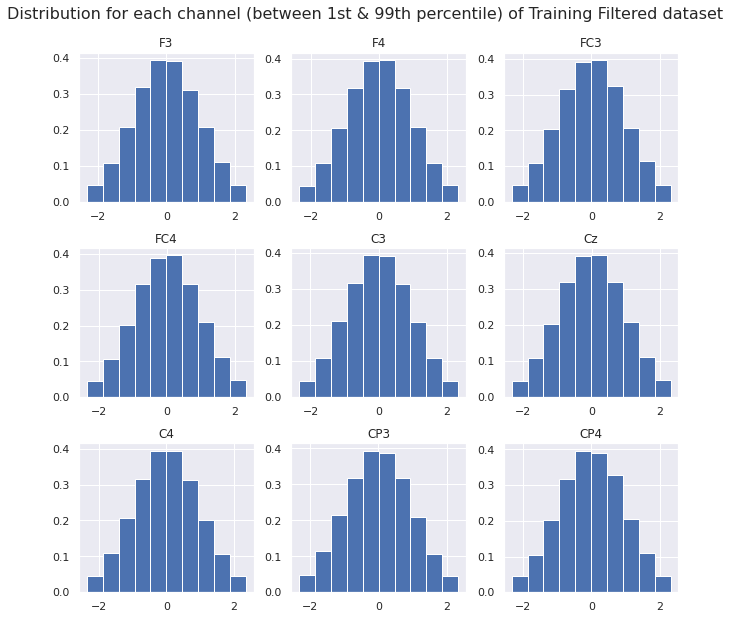

In [14]:
 data_summary(x_train, "Training Filtered")

##### Visualise the Raw & Scaled Signals

In [ ]:
labels=[(('F3',0), ('F4',1)), (('FC3',2), ('FC4',3)), (('C3',4), ('Cz',5), ('C4',6)), (('CP3',7), ('CP4',8))]
colours= ['darkslateblue', 'orange','lightskyblue','brown','darkgreen','darkgrey','bisque','violet','palegreen']

def plot_signals(sample, title=None):
  fig, axes = plt.subplots(2,2, figsize = (6,6))
  axes=axes.ravel()
  plt.suptitle("Signals" if title is None else title, size=16)
  count=0
  for label_group in labels:
    for label, ind in label_group:
      axes[count].plot(sample[:,ind], label=label,color=colours[ind], alpha=0.8)
      axes[count].legend()
    count+=1

# plot_signals(x_train[101], title="Scaled Signals - x_train[0]")
plot_signals(x_train_unscaled[101], title="Unscaled Signals - x_train[0]")
plot_signals(x_train_filtered[101], title="Filtered Signals - x_train[0]")
plot_signals(x_train[101], title="Scaled Signals - x_train[0]")

## Utility


#### Experiment Tracker


In [ ]:
class ExperimentTracker():

  def __init__(self):
      

## Autoencoders

#### Convolutional Autoencoder

##### Define a convolutional autoencoder.

This object-orientd implementation of the Convolutional Autoencoder allows to build an extra candidate architecture to be compared with the current architecture. In additions it includes several methods (that wrap native methdos from the class Model) to plot, evaluate and save a model easily while performing an experiment.

In [34]:
path_models = "/content/drive/MyDrive/ml2-eeg-biometrics/saved_models/"
path_encoders = "/content/drive/MyDrive/ml2-eeg-biometrics/saved_encoders/"

class ConvAutoencoder():

  def __init__(self, loss, optimizer, shape, parameters, candidate=False):
      self.input_shape = shape   
      self.encoder = None
      self.history = None
      print("Candidate build:", candidate)    
      self.autoencoder_model = self.build_candidate_model() if candidate else self.build_model(parameters['kernel_size'], parameters['filters'], parameters['pool_size'])
      self.autoencoder_model.compile(loss=loss, optimizer=optimizer)
      self.autoencoder_model.summary()
  

  ''' Builds the architecture of the model'''   
  def build_model(self, kernel_sizes, filters, pool_sizes):
      input_layer = Input(shape=self.input_shape)

      # encoder
      e1 = Conv1D(filters=filters[0], kernel_size=kernel_sizes[0], activation='relu', padding='same')(input_layer)
      e2 = MaxPooling1D(pool_size=pool_sizes[0])(e1)
      e3 = Conv1D(filters=filters[1], kernel_size=kernel_sizes[1], activation = 'relu', padding='same')(e2)
      e4 = MaxPooling1D(pool_size=pool_sizes[1])(e3)
      e5 = Conv1D(filters=filters[2], kernel_size=kernel_sizes[2], activation = 'relu', padding='same')(e4)
      e6 = MaxPooling1D(pool_size=pool_sizes[2])(e5)
      encoded = Flatten()(e6)
      print("Encoder size: ", encoded.type_spec.shape)
      self.encoder = encoded # save the encoder for later extraction

      # decoder
      d0 = Reshape((125,2))(encoded)
      d1 = UpSampling1D(size=pool_sizes[2])(d0)
      d2 = Conv1DTranspose(filters=filters[1], kernel_size=kernel_sizes[2], activation='relu', padding='same')(d1)    
      d3 = UpSampling1D(size=pool_sizes[1])(d2)
      d4 = Conv1DTranspose(filters=filters[2], kernel_size=kernel_sizes[1], activation='relu', padding='same')(d3)
      d5 = UpSampling1D(size=pool_sizes[0])(d4)
      decoded = Conv1DTranspose(filters=9, kernel_size=kernel_sizes[0], activation='linear', padding='same')(d5)

      model = Model(inputs=input_layer, outputs=decoded)
      model.output_shape
      return model


  ''' Builds the architecture of a candidate model, to be used in comparison with the current model'''   
  def build_candidate_model(self):
      print("No candidate build present, implement one first")
      return None

  ''' Trains the model on the full dataset and then saves the encoder part in a file'''
  def train_model_then_save(self, x_train, x_val, epochs, batch_size):
      self.train_model(x_train, x_val, epochs, batch_size)
      self.save_encoder(path_encoders, "encoder_" + str(epochs) +"epochs" + "_batchsize" + str(batch_size))

  ''' Trains the model on the full dataset, requires validation split'''                     
  def train_model(self, x_train, x_val, epochs, batch_size=20):
      early_stopping = EarlyStopping(monitor='loss',
                                      min_delta=0,
                                      patience=5,
                                      verbose=1, 
                                      mode='auto')
      self.history = self.autoencoder_model.fit(x_train, x_train,
                                            batch_size=batch_size,
                                            epochs=epochs,
                                            validation_data=(x_val, x_val),
                                            callbacks=[early_stopping])
      return self.history


  ''' Trains the model on a single channel, no validation split'''   
  def train_subset(self, x_train, epochs, batch_size=20):
      history = self.autoencoder_model.fit(x_train[:,:,0], x_train[:,:,0], epochs=epochs,
                  batch_size=batch_size,
                  # validation_split=0.05
                  )
      

  ''' Plots the history.
  input:
    history: if present, plot the history given as parameter
  output:
    None
  '''       
  def plot_history(self, history=None):
      history = history if history is not None else self.history
      plt.plot(history.history['loss'])
      plt.plot(history.history['val_loss'])
      plt.title('Model loss')
      plt.ylabel('Loss')
      plt.xlabel('Epoch')
      plt.legend(['Train', 'Test'], loc='upper left')
      plt.show()
      

  ''' Return the predictions for the trained data.
   input:
    X: the training data
   output:
    preds: predictions for the given training data
  '''       
  def eval_model(self, X):
      preds = self.autoencoder_model.predict(X)
      return preds


  ''' Save all model information, including weights, in h5 format
    input:
      path: full path on drive, for example /content/drive/MyDrive/ml2-eeg-biometrics/saved_models/
    output:
      None
  '''    
  def save_model(self, path, label=''):
      timestamp = pd.Timestamp.now()
      model_name = label + "_" + str(timestamp) + ".h5"
      saved_model = self.autoencoder_model.save(path + model_name)
      print("Model saved at " + str(timestamp) + " in path " + path)

  
  ''' Save the encoder part of the model, including weights, in h5 format
    input:
      path: full path on drive, for example /content/drive/MyDrive/ml2-eeg-biometrics/saved_models/
    output:
      None
  '''    
  def save_encoder(self, path, label=''):
      timestamp = pd.Timestamp.now()
      model_name = label + "_" + str(timestamp) + ".h5"
      encoder = Model(self.autoencoder_model.input, self.encoder)
      saved_encoder = encoder.save(path + model_name)
      print("Encoder saved at " + str(timestamp) + " in path " + path)

  ''' Retrieve the history of the model.
  input:
    None
  output:
    history: history saved in the object model
  '''
  def retrieve_history(self):
      return self.history


  ''' Retrieve the encoder part of the model.
  input:
    index: the index of the encoded layer
  output:
    encoder: a model built with the input layer as input and the encoded layer as output
  '''
  def retrieve_encoder(self, index):
      encoder = Model(self.autoencoder_model.input, self.autoencoder_model.get_layer(index=index).output)
      return encoder
  

  ''' Assess the model on a subset of data
  input:
    X: the training data
  output:
    None
  '''
  def assess_subset(self, X):
    x_pred = self.eval_model(X)
    for i in range(0,len(x_1),200):
      plt.plot(x_1[i,:,0], label='actual')
      plt.plot(x_pred[i,:,0], label = 'predicted')
      plt.show()


  ''' Plot prediction for the model.
  input:
    X: the training data
  output:
    None
  '''
  def plot_prediction(self, X):
    x_pred = candidate_model.eval_model(X)
    plt.figure(figsize=(14,8))
    plt.plot(X[1039,:,0], label='actual', alpha=0.7)
    plt.plot(x_pred[1039,:,0], label= 'predicted',alpha=0.7)
    # plt.ylim(0.475, 0.495)
    plt.legend()

  ''' Plot the distribution of the loss across the dataset
  input:
    X_pred: prediction on the training data (obtainable from eval_model())
    X_train: the training data
  output:
    None
  '''
  def plot_loss_distribution(self, X_pred, x_train):
    x_train_reshaped = x_train.reshape(x_train.shape[0]*x_train.shape[1], x_train.shape[2])
    loss_mae = np.mean(np.abs(X_pred-x_train_reshaped), axis = 1)
    plt.figure(figsize=(16,9), dpi=80)
    plt.title('Loss Distribution', fontsize=16)
    sns.distplot(loss_mae, bins = 20, kde= True, color = 'blue');
    plt.xlim([0.0,.5])
    

  """ Function to plot predictions vs. the actuals for one sample.
  input:
    actuals   3D array (n_samplesx2500x9) - Original scaled signals.
    pred      the predicted values corresponding to the actuals.
    ind     The row number of the sample (2500x9) that you want to compare.
    rescale   If set to true then the data is first converted back to the original scale for comparison.
  
  returns:
    nothing

  prints plots.
  """
  def evaluate_prediction(self, actuals, pred, ind, rescale=False):
    cols = ['F3', 'F4', 'FC3', 'FC4', 'C3', 'Cz', 'C4', 'CP3', 'CP4']

    if rescale:
      sample_actual = scaler.inverse_transform(actuals[ind]) # Rescale to the original scale.
      sample_pred = scaler.inverse_transform(pred[ind]) 
    else:
      sample_actual = actuals[ind]    # Get the relevant sample.
      sample_pred = pred[ind]

    mae_by_channel = np.mean(np.abs(sample_pred - sample_actual), axis=0) # Get the Mean Absolute Error for each channel for this sample
    sample_mae = np.mean(mae_by_channel) # Get the total MAE for the sample by taking the average across the 9 channels
    print("Sample", ind, "\n   Total Mean Absolute Error:", round(sample_mae, 8))
    print("Mean Absolute Error by Channel:")
    for col, error in zip(cols, mae_by_channel):
      print(col, ": ", round(error,8)) 

    fig, axes = plt.subplots(3,3, figsize=(9,9))
    axes=axes.ravel()

    for i in range(9):
      axes[i].plot(sample_actual[:,i], label= "Actual")
      axes[i].plot(sample_pred[:,i], label="Predicted")
      axes[i].title.set_text(cols[i] + str(round(mae_by_channel[i], 3)))
    
    plt.legend()
    fig.suptitle("Predictions vs. Actuals - Sample " + str(ind),size=16)
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])

  ''' Plot loss distribution of the test set for each channel.
  input:
    X_test: the test data 
  output:
    None
  '''
  def plot_loss_test(self, x_test):
    X_pred = self.eval_model(x_test)
    X_pred = X_pred.reshape(X_pred.shape[0]*X_pred.shape[1], X_pred.shape[2])

    x_test_reshaped = x_test.reshape(x_test.shape[0]*x_test.shape[1], x_test.shape[2])
    fig, axes = plt.subplots(9,1, figsize=(18,9))
    # Plot the loss distribution for each channel individually
    for i in range(x_test_reshaped.shape[1]):
      loss_mae = np.abs(X_pred[:,i]-x_test_reshaped[:,i])
      sns.distplot(loss_mae, bins = 100, kde= True, color = 'blue', ax=axes[i]);
      axes[i].axis(xmin=0.0,xmax=0.2)

##### Fit the model.

In [35]:
# create the autoencoder model with the current architecture
optimizer = Adam(lr=0.001)
shape = (x_train.shape[1], x_train.shape[2])
parameters = {
          "kernel_size": [9, 5, 3], 
          "filters": [18, 6, 2],
          "pool_size": [2, 5, 2]
      }
      
model = ConvAutoencoder(loss='mae', optimizer=optimizer, shape=shape, parameters=parameters)


Candidate build: False
Encoder size:  (None, 250)
Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 2500, 9)]         0         
_________________________________________________________________
conv1d_21 (Conv1D)           (None, 2500, 18)          1476      
_________________________________________________________________
max_pooling1d_21 (MaxPooling (None, 1250, 18)          0         
_________________________________________________________________
conv1d_22 (Conv1D)           (None, 1250, 6)           546       
_________________________________________________________________
max_pooling1d_22 (MaxPooling (None, 250, 6)            0         
_________________________________________________________________
conv1d_23 (Conv1D)           (None, 250, 2)            38        
_________________________________________________________________
max_pooli

In [ ]:
# create the autoencoder model with the candidate architecture
optimizer = Adam(lr=0.001)
shape = (x_train.shape[1], x_train.shape[2])
candidate_model = ConvAutoencoder(loss='mae', optimizer=optimizer, shape=shape, candidate=True)

In [ ]:
# Train both current and candidate models

# fit the model to the data
nb_epochs = 1
batch_size = 20
x_1 = x_train[:,:,:]
## Train the models on the full dataset
print('Training Current model for ' + str(nb_epochs) + " epochs and batch size of " + str(batch_size))
model.train_model_then_save(x_1, x_valid, nb_epochs, batch_size)
print('============================================================')
print('Training Candidate model for ' + str(nb_epochs) + " epochs and batch size of " + str(batch_size))
#candidate_model.train_model(x_1, x_valid, nb_epochs, batch_size)
print('============================================================')

In [ ]:
# Obtain the encoder part of the models.
encoder = candidate_model.retrieve_encoder(index=7)
# encoder.summary()

train_pred = encoder.predict(x_train)
valid_pred = encoder.predict(x_valid)

timestamp = pd.Timestamp.now()
np.save(dirpath + "train_encoding_" + candidate_model.autoencoder_model.name + "_" + str(timestamp) + ".npy", train_pred)
np.save(dirpath + "valid_encoding_" + candidate_model.autoencoder_model.name + "_" + str(timestamp) + ".npy", valid_pred)

In [ ]:
model.plot_history()
candidate_model.plot_history()

##### Plot the reconstruction for individual samples.
Temporary code for assessing the models on the subset of data (one channel and only 20% of timepoints).

In [ ]:
# model.assess_subset(x_1)
candidate_model.assess_subset(x_1)


Plot prediction for the whole dataset

In [ ]:
model.plot_prediction(x_1)
candidate_model.plot_prediction(x_1)


## Evaluate Results

In [ ]:
# Get the predicted values for the training set.
X_pred_3D = model.eval_model(x_train)
# X_pred_3D = candidate_model.eval_model(x_train_f)
X_pred = X_pred_3D.reshape(X_pred_3D.shape[0]*X_pred_3D.shape[1], X_pred_3D.shape[2])
# X_pred = pd.DataFrame(X_pred, columns=train.columns)

##### Plot distribution of the loss

In [ ]:
# Plot the distribution of the loss
model.plot_loss_distribution(X_pred, x_train)
# candidate_model.plot_loss_distribution(X_pred, x_train)

##### Evaluate total re-construction for one sample

In [ ]:
model.evaluate_prediction(x_train, X_pred_3D, ind=1, rescale=False)
# candidate_model.evaluate_prediction(x_train, X_pred_3D, ind=1, rescale=False)

##### Plot the loss distribution of the test set (code from tutorial, needs to be edited).

In [ ]:
# plot the loss distribution of the test set
model.plot_loss_test(x_test)
# candidate_model.plot_loss_test(x_test)

In [ ]:
model.save_model(path_models, "model_20epochs") # Get current timestamp and model number.
